In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
AQI_BREAKPOINTS = {
    "pm25": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 500.4, 301, 500)
    ],
    "pm10": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 604, 301, 500)
    ],
    "so2": [
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 1004, 301, 500)
    ]
}

# --- Categorías ---
AQI_CATEGORIES = [
    (0, 50, "Bueno"),
    (51, 100, "Moderado"),
    (101, 150, "Insalubre para grupos sensibles"),
    (151, 200, "Insalubre"),
    (201, 300, "Muy insalubre"),
    (301, 500, "Peligroso")
]

def calc_aqi_subindex(value, pollutant):
    """Calcula el subíndice AQI para un contaminante dado"""
    for (c_low, c_high, i_low, i_high) in AQI_BREAKPOINTS[pollutant]:
        if c_low <= value <= c_high:
            return ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
    return None  # fuera de rango

def categorize_aqi(aqi_value):
    """Devuelve la categoría textual del AQI"""
    for (low, high, cat) in AQI_CATEGORIES:
        if low <= aqi_value <= high:
            return cat
    return "Fuera de rango"

def calculate_aqi(row,stat='mean'):
    """Calcula el AQI total y categoría a partir de una fila con pm25, pm10, so2"""
    subindices = []
    for pollutant in ["pm25", "pm10", "so2"]:
        if pd.notnull(row[f"{pollutant}_{stat}"]):
            si = calc_aqi_subindex(row[f"{pollutant}_{stat}"], pollutant)
            if si is not None:
                subindices.append(si)
    if not subindices:
        return pd.Series([None, None])
    
    aqi = max(subindices)  # el AQI es el máximo de los subíndices
    category = categorize_aqi(aqi)
    return pd.Series([aqi, category])

In [20]:
class LagAnalyzer:
    """
    Análisis de lags (ACF, PACF y CCF) para una serie temporal.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con índice temporal y columnas numéricas.
    target : str
        Nombre de la variable objetivo (ej: 'AQI').
    covars : list[str]
        Lista de nombres de covariables a analizar.
    max_lag : int
        Máximo lag (± max_lag) para CCF y max_lag para ACF/PACF.
    """

    def __init__(self, df: pd.DataFrame, target: str, covars: list[str], max_lag: int = 72):
        self.df = df
        self.target = target
        self.covars = covars
        self.max_lag = max_lag
        self.top_lags_: dict[str, pd.DataFrame] = {}

    # ------------------- MÉTODOS PÚBLICOS -------------------

    def plot_target_acf_pacf(self) -> None:
        """Plotea ACF y PACF del target."""
        fig, ax = plt.subplots(2, 1, figsize=(12, 8))
        plot_acf(self.df[self.target].dropna(), lags=self.max_lag, ax=ax[0])
        ax[0].set_title(f"ACF {self.target}")
        plot_pacf(self.df[self.target].dropna(), lags=self.max_lag, ax=ax[1])
        ax[1].set_title(f"PACF {self.target}")
        plt.tight_layout()
        plt.show()

    def analyze_covariables(self, top_n: int = 5, plot: bool = True) -> dict[str, pd.DataFrame]:
        """
        Calcula CCF por covariable y guarda los top lags por |corr| en self.top_lags_.
        Devuelve un dict: {covariable: DataFrame(top_n lags)}.
        """
        self.top_lags_ = {}
        for c in self.covars:
            df_ccf = self._ccf(self.df[self.target], self.df[c], self.max_lag)
            top = df_ccf.reindex(df_ccf["corr"].abs().sort_values(ascending=False).index).head(top_n)
            self.top_lags_[c] = top

            if plot:
                self._plot_ccf(df_ccf, cov_name=c)

        return self.top_lags_

    def summary(self) -> None:
        """Imprime por consola los top lags calculados."""
        if not self.top_lags_:
            print("No se han calculado top lags aún. Llama a analyze_covariables().")
            return
        for c, df_lags in self.top_lags_.items():
            print(f"\n=== Top lags para {c} ===")
            print(df_lags)

    # ------------------- MÉTODOS PRIVADOS -------------------

    @staticmethod
    def _ccf(x: pd.Series, y: pd.Series, max_lag: int) -> pd.DataFrame:
        """Cross-correlation normalizada entre x (target) e y (covariable)."""
        df_xy = pd.concat([x, y], axis=1).dropna()
        x_c = df_xy.iloc[:, 0].values
        y_c = df_xy.iloc[:, 1].values

        x_c = x_c - x_c.mean()
        y_c = y_c - y_c.mean()

        n = len(x_c)
        corr_full = np.correlate(x_c, y_c, mode="full")
        lags_full = np.arange(-n + 1, n)

        denom = np.std(x_c) * np.std(y_c) * n
        corr_full = corr_full / denom

        mask = (lags_full >= -max_lag) & (lags_full <= max_lag)
        return pd.DataFrame({"lag": lags_full[mask], "corr": corr_full[mask]}).reset_index(drop=True)

    @staticmethod
    def _plot_ccf(df_lags: pd.DataFrame, cov_name: str) -> None:
        """Plot simple de CCF para una covariable."""
        plt.figure(figsize=(10, 3))
        plt.stem(df_lags["lag"], df_lags["corr"])
        plt.axhline(0, color="black", linewidth=0.8)
        plt.title(f"CCF {cov_name} vs target")
        plt.xlabel("Lag")
        plt.ylabel("Correlación")
        plt.tight_layout()
        plt.show()

In [4]:
gcp_paths = [
     "gs://pollution-data-mlops/hist/sensors_measurements_202401.parquet",
     "gs://pollution-data-mlops/hist/sensors_measurements_2024_02_12.parquet",
     "gs://pollution-data-mlops/hist/sensors_measurements_2025_01_08.parquet",
]

df_list = [pd.read_parquet(path,storage_options={"token": "google_default"}) for path in gcp_paths]

In [5]:
df_all = pd.concat(df_list, ignore_index=True)
df_wide = df_all.pivot_table(index="datetime_from_utc", 
                columns="parameter",
                values = "value",
                #aggfunc = ["min","mean","max"]
                aggfunc = ["mean"]
              )
df_wide.columns = [f"{param}_{stat}" for stat, param in df_wide.columns]
df_wide[["AQI", "AQI_category"]] = df_wide.apply(calculate_aqi, axis=1)
df_wide["day"] = pd.to_datetime(df_wide.index).day
df_wide["hour"] = pd.to_datetime(df_wide.index).hour
df_wide["month"] = pd.to_datetime(df_wide.index).month
df_wide["yearmonth"] = pd.to_datetime(df_wide.index).to_period("M").astype(str)

/tmp/ipykernel_45184/2156688787.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_wide["yearmonth"] = pd.to_datetime(df_wide.index).to_period("M").astype(str)


In [6]:
df_wide.info()
covariables = df_wide.columns[0:7]
target = "AQI"

<class 'pandas.core.frame.DataFrame'>
Index: 13837 entries, 2024-01-01T00:00:00Z to 2025-07-31T23:00:00Z
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pm1_mean               5012 non-null   float64
 1   pm10_mean              13817 non-null  float64
 2   pm25_mean              13818 non-null  float64
 3   relativehumidity_mean  5012 non-null   float64
 4   so2_mean               11507 non-null  float64
 5   temperature_mean       5012 non-null   float64
 6   um003_mean             5012 non-null   float64
 7   AQI                    13837 non-null  float64
 8   AQI_category           13837 non-null  object 
 9   day                    13837 non-null  int32  
 10  hour                   13837 non-null  int32  
 11  month                  13837 non-null  int32  
 12  yearmonth              13837 non-null  object 
dtypes: float64(8), int32(3), object(2)
memory usage: 1.3+ MB


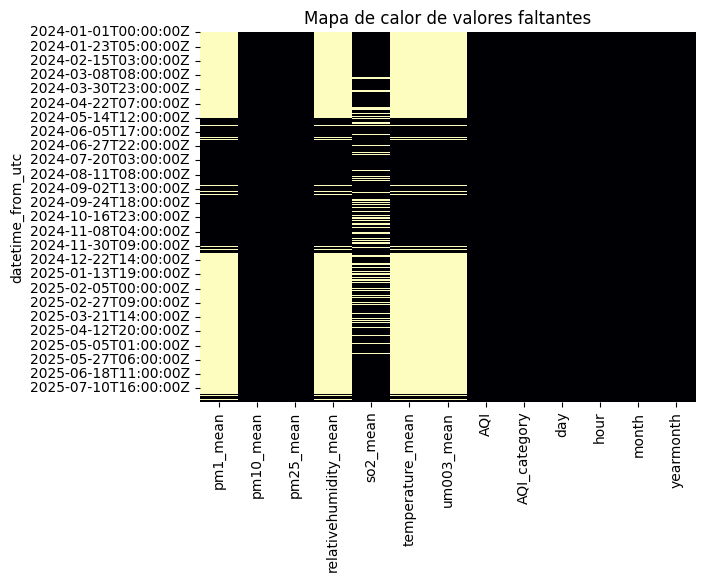

In [7]:
sns.heatmap(df_wide.isnull(),cmap="magma",cbar=False)
plt.title("Mapa de calor de valores faltantes")
plt.show()

/tmp/ipykernel_45184/1065814702.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  max_fecha = df_wide[:'2024-12-31T00:00:00Z'][~(df_wide.pm1_mean.isnull())].sort_index().iloc[-1].name


<Axes: ylabel='datetime_from_utc'>

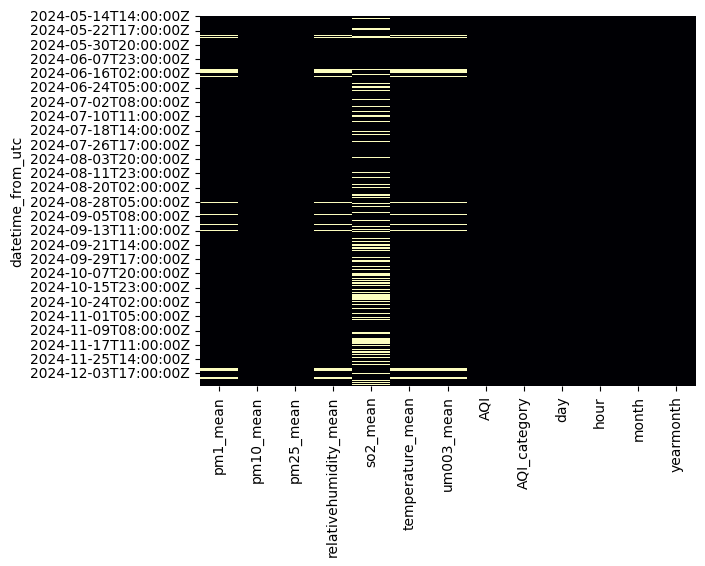

In [8]:
min_fecha = df_wide[~(df_wide.pm1_mean.isnull())].sort_index().iloc[0].name
max_fecha = df_wide[:'2024-12-31T00:00:00Z'][~(df_wide.pm1_mean.isnull())].sort_index().iloc[-1].name

df_analysis = df_wide[min_fecha:max_fecha].copy()
sns.heatmap(df_analysis.isnull(),cmap="magma",cbar=False)

### 1: Target analysis

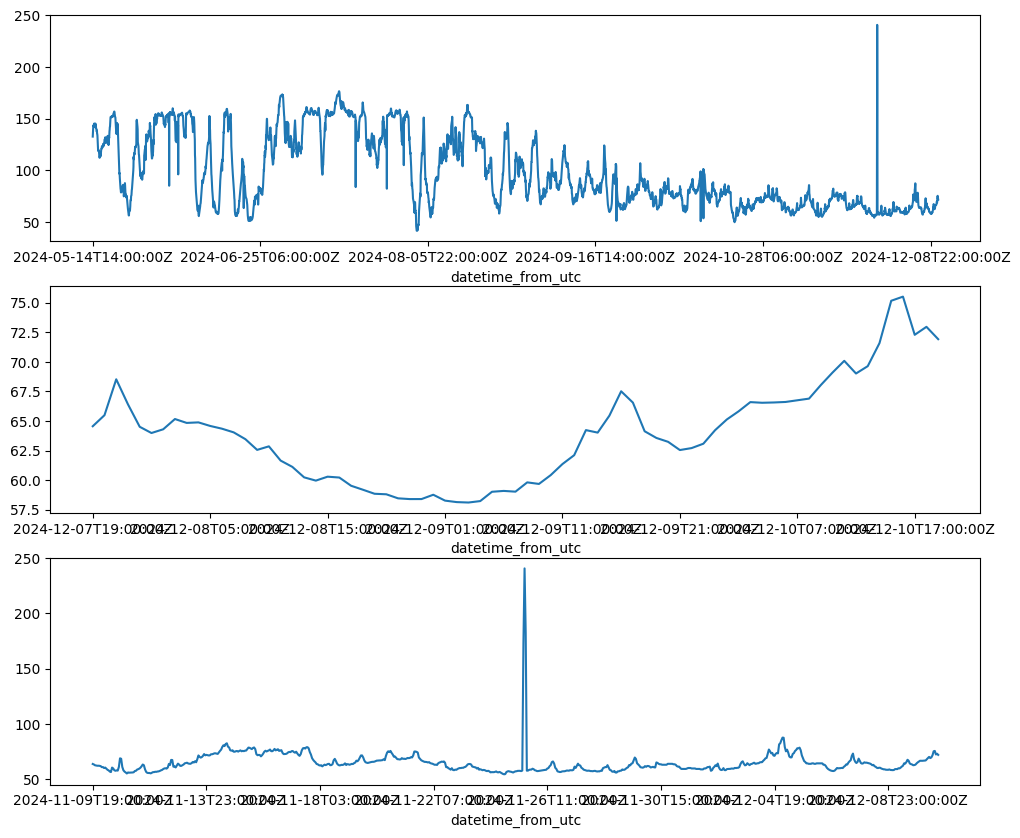

In [9]:
def plot_timeseries(df,target,last_date, hours=72, days=31 ):
    fig,ax = plt.subplots(3,1,figsize=(12,10))
    ## Complete TS
    df[target].plot(ax=ax[0])
    
    ## Last xx hours
    end_dt = datetime.fromisoformat(last_date.replace("Z", "+00:00"))
    ini_dt = end_dt - relativedelta(hours=hours)
    last_date_H = ini_dt.isoformat().replace("+00:00", "Z")
    df_analysis[last_date_H:last_date][target].plot(ax=ax[1])

    ## Last xx days
    end_dt = datetime.fromisoformat(last_date.replace("Z", "+00:00"))
    ini_dt = end_dt - relativedelta(days=days)
    last_date_D = ini_dt.isoformat().replace("+00:00", "Z")
    df_analysis[last_date_D:last_date][target].plot(ax=ax[2])

plot_timeseries(df_analysis,'AQI',max_fecha)

<Axes: xlabel='month', ylabel='AQI'>

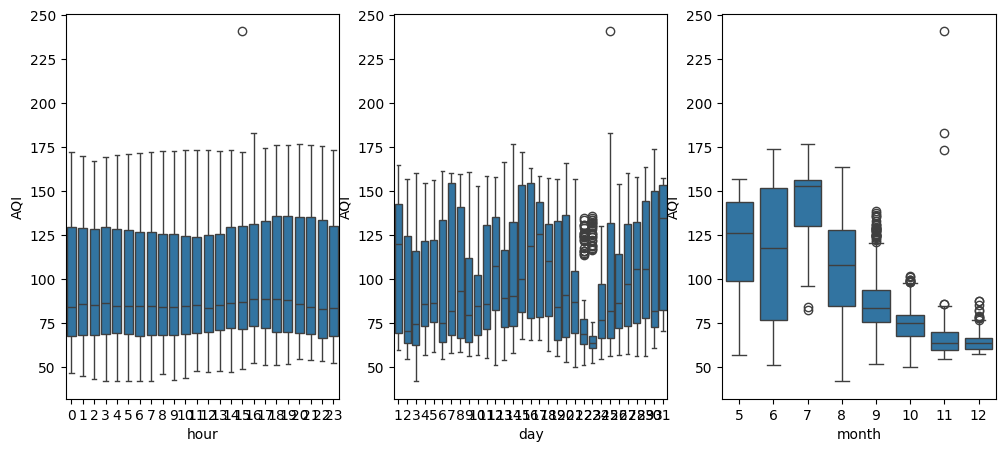

In [10]:
fig,ax = plt.subplots(1,3,figsize=(12,5))
sns.boxplot(x='hour', y='AQI', data=df_analysis,ax=ax[0])
sns.boxplot(x='day', y='AQI', data=df_analysis,ax=ax[1])
sns.boxplot(x='month', y='AQI', data=df_analysis,ax=ax[2])

In [11]:
df_analysis[['hour','day','month','AQI']].corr()

,hour,day,month,AQI
hour,1.000000,0.000336,-0.005396,0.027942
day,0.000336,1.000000,-0.208684,0.031567
month,-0.005396,-0.208684,1.000000,-0.657016
AQI,0.027942,0.031567,-0.657016,1.000000


<Axes: xlabel='hour'>

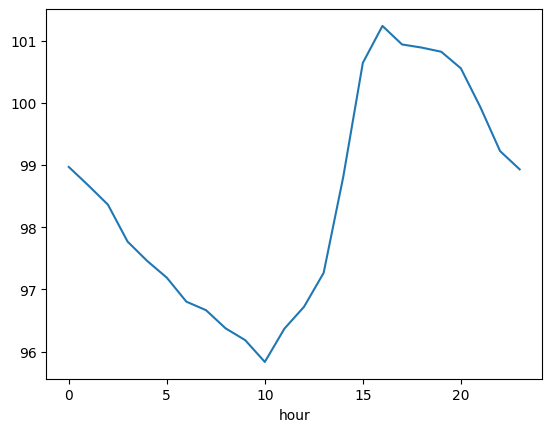

In [12]:
df_analysis.groupby("hour")["AQI"].mean().plot()

### 2: Covariates

<Axes: >

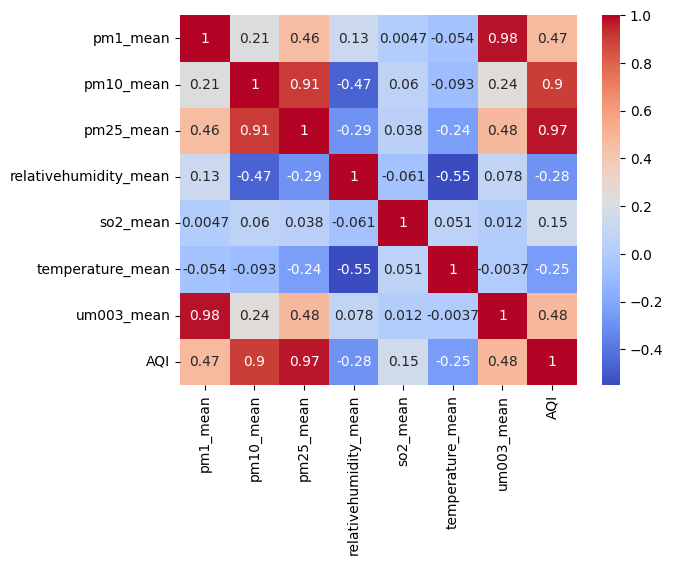

In [13]:
sns.heatmap(df_analysis[covariables.tolist()+[target]].corr(),
            cmap='coolwarm', annot=True)

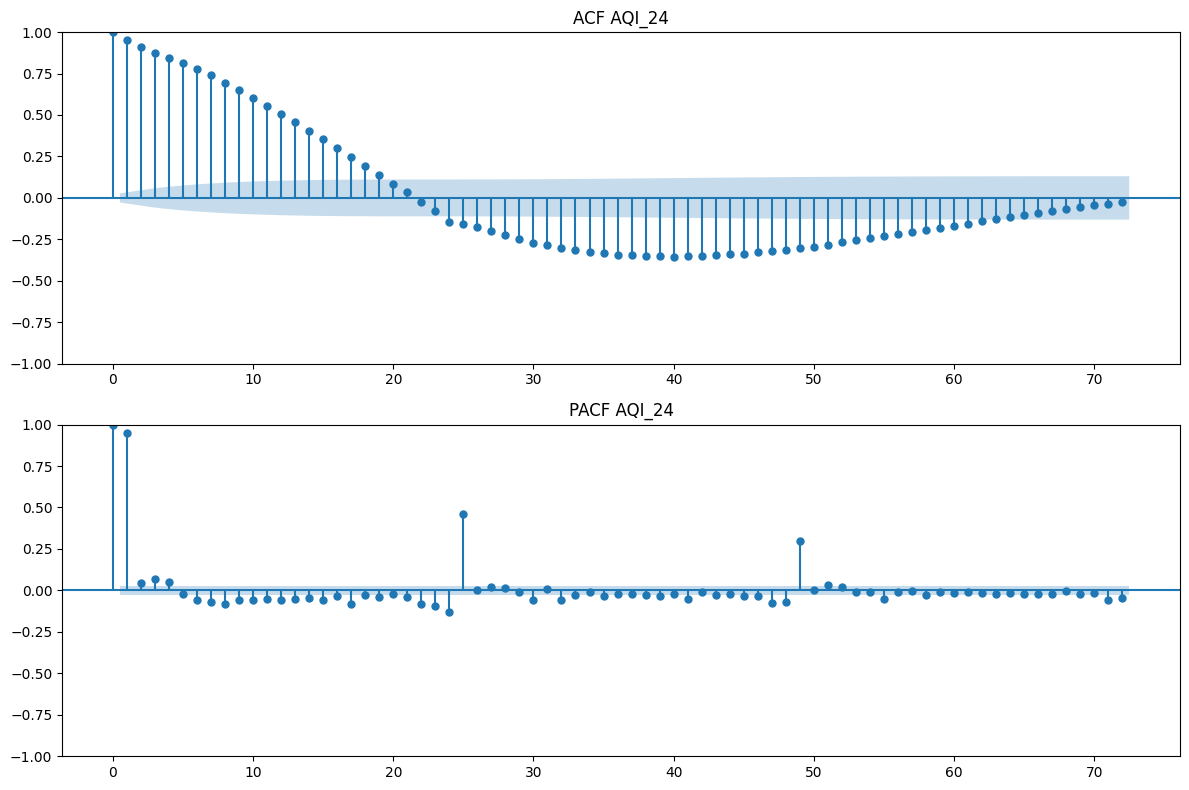

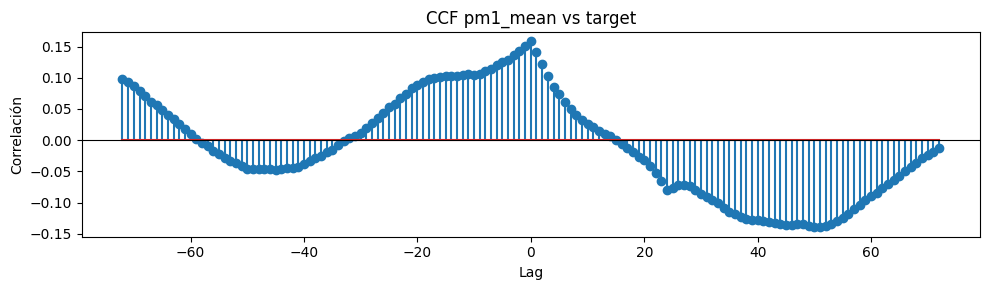

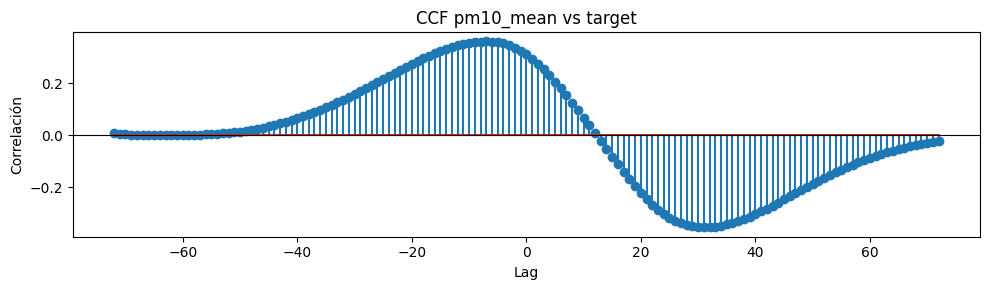

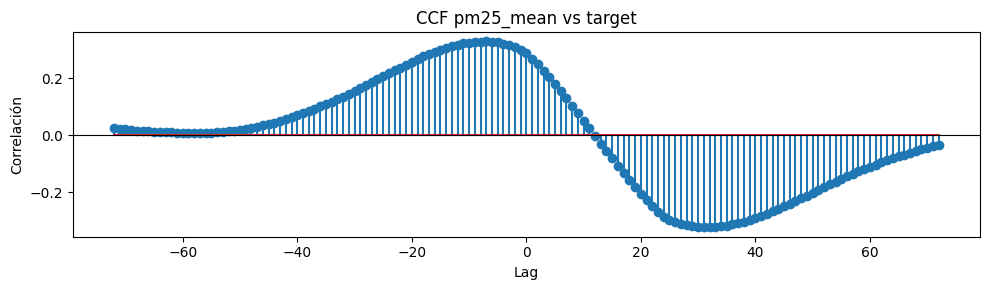

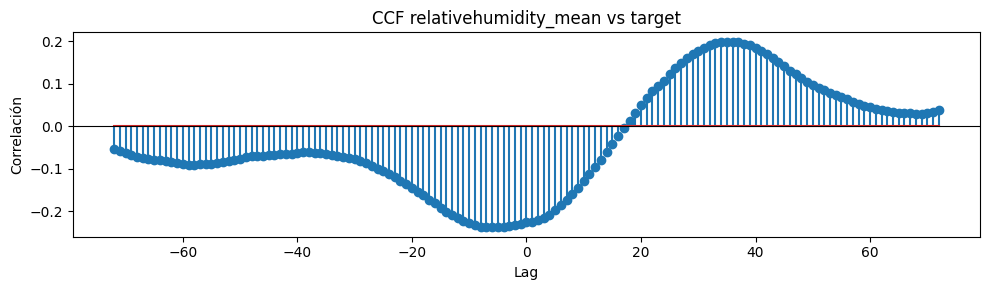

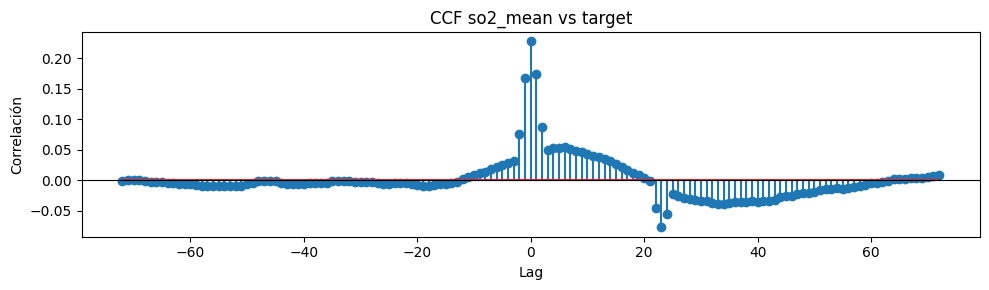

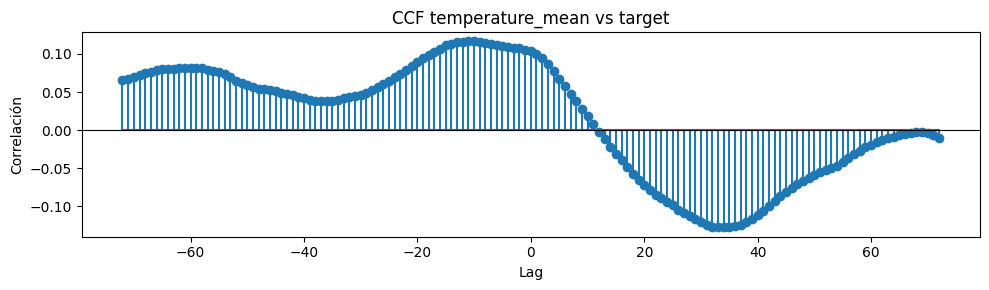

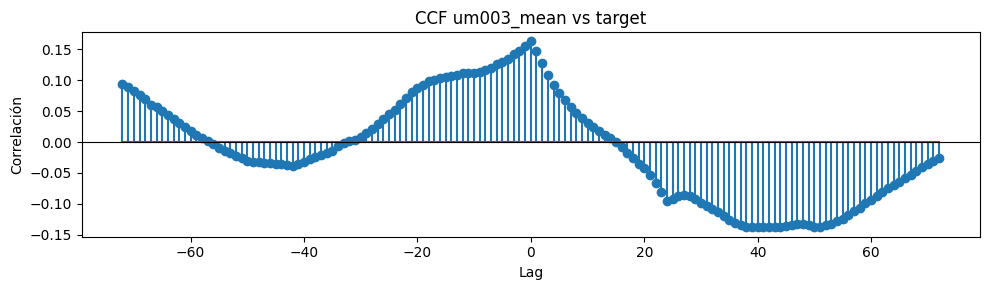


=== Top lags para pm1_mean ===
     lag      corr
72     0  0.158324
71    -1  0.150765
70    -2  0.142257
73     1  0.141371
123   51 -0.139805

=== Top lags para pm10_mean ===
    lag      corr
65   -7  0.360046
64   -8  0.359396
66   -6  0.359108
63   -9  0.357262
67   -5  0.356443

=== Top lags para pm25_mean ===
    lag      corr
65   -7  0.329938
64   -8  0.329309
66   -6  0.329062
63   -9  0.327713
67   -5  0.326403

=== Top lags para relativehumidity_mean ===
    lag      corr
65   -7 -0.238291
66   -6 -0.238112
67   -5 -0.237540
64   -8 -0.237128
68   -4 -0.236599

=== Top lags para so2_mean ===
    lag      corr
72    0  0.227296
73    1  0.174231
71   -1  0.168092
74    2  0.086959
95   23 -0.077264

=== Top lags para temperature_mean ===
     lag      corr
105   33 -0.127621
106   34 -0.127548
107   35 -0.126982
104   32 -0.126827
108   36 -0.125948

=== Top lags para um003_mean ===
    lag      corr
72    0  0.163026
71   -1  0.155809
70   -2  0.147564
73    1  0.147146
6

In [22]:
df_analysis['AQI_24'] = df_analysis.AQI.diff(24)
analyzer = LagAnalyzer(df=df_analysis, target='AQI_24', covars=covariables, max_lag=72)
analyzer.plot_target_acf_pacf()
analyzer.analyze_covariables(top_n=5, plot=True)
analyzer.summary()